[#air-polution-sensor](https://github.com/Johansmm/air-polution-sensor)

 # Analyse spatio-temporelle de signaux pour détecter la dérive de capteurs mesurant la qualité de l'air
 
The network of sensors allows to follow a complex phenomenon by observing the temporal evolution of the values in several points, and by crossing the information from one sensor to another. This allows, for example, to carry out a meteorological or seismic monitoring, by detecting a cloud or a tremor. However, the sensors used are sometimes subject to drift, wear and tear or possible interference, which makes some of the observed values false. It is therefore important to be able to determine if a sensor starts to drift in order to allow a good analysis of the data. Therefore, the objective of this project is to detect a drifting sensor (when and where) in a real sensor's network. For this, we will explore the usefulness of a particular mathematical tool: the graph space-time spectrogram. Such a tool allows to decompose a space-time series into a sum of space-time frequencies, in a similar way to Fourier analysis, but for signals in graphs.

In [1]:
# Libraries
%load_ext autoreload
%autoreload 2

# Basis libraries 
import sys, getpass, os, copy
import numpy as np
import scipy.signal
from matplotlib import rc
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import scipy.signal

# Library for boxplots
# font = {'family':'sans-serif','sans-serif':['Helvetica'], 'size':18}
# rc('font', **font)
# rc('text', usetex=True)

np.random.seed(0)

In [2]:
# Colab access
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

# If you work-directory don't match, please add the new path to pwd_list
cwd_list = ["/content/gdrive/My Drive/S5 Project: Air polution/air-polution-sensor/",
            "/content/gdrive/My Drive/Colab Notebooks/ProyectS5/air-polution-sensor/",
            "/content/gdrive/MyDrive/IMT Atlantique/Project_S5_Air/air-polution-sensor/"
            "/content/drive/MyDrive/IMT Atlantique/Project_S5_Air/air-polution-sensor/",
            os.path.join(os.getcwd(),"air-polution-sensor")]

for cwd in cwd_list:
    if os.path.isdir(cwd):
        %cd "$cwd"
        break
if os.path.split(os.getcwd())[-1] != "air-polution-sensor":
    print("[WARNING]: Incorrect working directory. Please add the fix-directory to the pwd_list.")
else: 
    print("[INFO]: Work directory: " + os.getcwd())

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/ProyectS5/air-polution-sensor
[INFO]: Work directory: /content/gdrive/My Drive/Colab Notebooks/ProyectS5/air-polution-sensor


## **Download database**
Initially, the project [air-polution-sensor](https://github.com/Johansmm/air-polution-sensor.git) contains some default databases, which must be decompressed. Additionally, a larger database should be downloaded. This process is presented below.

Note: Make sure you are inside the repository folder [air-polution-sensor](https://github.com/Johansmm/air-polution-sensor.git).

In [3]:
if not os.path.isdir("./data/origin_data"):
    if not os.path.isdir("./data"): os.mkdir("./data")
    if not os.path.isdir("./data/origin_data"): os.mkdir("./data/origin_data")
    !wget --output-document="./data/data.zip" "https://www.dropbox.com/sh/w1704rg9fd9z4pq/AABG3YCUMHTwbFhf3pKgti-Qa/PuneData_UseThis/August2019?dl=0&subfolder_nav_tracking=1"
    !unzip "./data/data.zip" -d "./data/origin_data"

if not os.path.isfile("./data/super_df.csv"):
    !unrar x "./data/super_df.rar" "./data/"

clear_output(wait = True)
print("[INFO]: Data downloaded successfully!")

[INFO]: Data downloaded successfully!


In [4]:
# Specific libraries
!pip install -r requirements.txt
from libraries.global_functions import *
from libraries.animation_utils import *

clear_output(wait = True)
print("[INFO]: Successfully loaded libraries!")

[INFO]: Successfully loaded libraries!


In [5]:
# !sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config

## **Handling of NAN Values**


In order to obtain a good representation in the spectrogram is necessary to tame the NAN values that have the data provided by the sensors, for this reason we used a python library called fancyimpute that is very useful to perform data imputation, with different algorithms such as matrix completion, matrix completion by iterative low-rank SVD decomposition or nuclear norm minimization.

### Test in interval of the time series with fancyimpute


First, the dataframe is read where all the sensor data is contained in the time intervals that are interesting to observe.

In [6]:
super_df = pd.read_csv('./data/superdfi.csv', header=0, index_col=0)

A dataframe sample is taken from the data of three sensors and the NAN values are removed.

In [7]:
df_nonan = super_df[(super_df['Sensor'] == 'sensor14v2.csv') | (super_df['Sensor'] == 'sensor13v2.csv') | (super_df['Sensor'] == 'sensor12v2.csv')]
df_nonan =df_nonan.dropna().reset_index()

In [8]:
aux = df_nonan.drop(columns=['index', 'Sensor', 'Date', 'Hour'])
aux.head()

PM2_MIN  PM2_MAX  PM2_MOY
0      8.0      9.0      8.0
1      8.0      9.0      8.0
2      8.0      9.0      8.0
3      8.0      9.0      8.0
4      8.0      9.0      8.0

We transform the df into a numpy vector and randomly replace existing values with NAN values, we also create a mask of the positions of these values for later comparison.

In [9]:
df_nonanArr = aux.to_numpy()
arr_incomplete =  np.copy(df_nonanArr)
missing_raw_values = np.random.uniform(0, 1, df_nonanArr.shape)
missing_mask = missing_raw_values < 0.25
arr_incomplete[missing_mask] = np.nan

###  Matrix completion by iterative low-rank SVD decomposition

The following function will be in charge of evaluating the performance of the model.

In [10]:
def reconstruction_error(XY, XY_completed, missing_mask, name=None):
    """
    Returns mean squared error and mean absolute error for
    completed matrices.
    """
    value_pairs = [
        (i, j, XY[i, j], XY_completed[i, j])
        for i in range(XY.shape[0])
        for j in range(XY.shape[1])
        if missing_mask[i, j]
    ]
    print("First 10 reconstructed values:")
    for (i, j, x, xr) in value_pairs[:10]:
        print("  (%d,%d)  %0.4f ~= %0.4f" % (i, j, x, xr))
    diffs = [actual - predicted for (_, _, actual, predicted) in value_pairs]
    missing_mse = np.mean([diff ** 2 for diff in diffs])
    missing_mae = np.mean([np.abs(diff) for diff in diffs])
    print("%sMSE: %0.4f, MAE: %0.4f" % (
        "" if not name else name + " ",
        missing_mse,
        missing_mae))
    return missing_mse, missing_mae

In [11]:
from fancyimpute import IterativeSVD

def test_iterative_svd():
    solver = IterativeSVD(rank=1, convergence_threshold=0.00000001)
    arr_completed = solver.fit_transform(arr_incomplete)
    _, missing_mae = reconstruction_error(
        df_nonanArr,
        arr_completed,
        missing_mask,
        name="IterativeSVD")
    return arr_completed


arr_completedSVD = test_iterative_svd()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



[IterativeSVD] Iter 1: observed MAE=1.935099
[IterativeSVD] Iter 2: observed MAE=1.153091
[IterativeSVD] Iter 3: observed MAE=0.906071
[IterativeSVD] Iter 4: observed MAE=0.819781
[IterativeSVD] Iter 5: observed MAE=0.776393
[IterativeSVD] Iter 6: observed MAE=0.748792
[IterativeSVD] Iter 7: observed MAE=0.730064
[IterativeSVD] Iter 8: observed MAE=0.716992
[IterativeSVD] Iter 9: observed MAE=0.707739
[IterativeSVD] Iter 10: observed MAE=0.701101
[IterativeSVD] Iter 11: observed MAE=0.696335
[IterativeSVD] Iter 12: observed MAE=0.693034
[IterativeSVD] Iter 13: observed MAE=0.690512
[IterativeSVD] Iter 14: observed MAE=0.688600
[IterativeSVD] Iter 15: observed MAE=0.687138
[IterativeSVD] Iter 16: observed MAE=0.686019
[IterativeSVD] Iter 17: observed MAE=0.685160
[IterativeSVD] Iter 18: observed MAE=0.684498
[IterativeSVD] Iter 19: observed MAE=0.683988
[IterativeSVD] Iter 20: observed MAE=0.683593
[IterativeSVD] Iter 21: observed MAE=0.683289
[IterativeSVD] Iter 22: observed MAE=0.6830

The resulting matrix is converted back into df 

In [12]:
arr_completedSVD = pd.DataFrame(arr_completedSVD, columns = ['PM2_MIN','PM2_MAX','PM2_MOY'])
arr_completedSVD[['Sensor', 'Date', 'Hour']] = df_nonan[['Sensor', 'Date', 'Hour']]
arr_completedSVD = arr_completedSVD[['Sensor', 'Date', 'Hour', 'PM2_MIN', 'PM2_MAX', 'PM2_MOY']]
arr_completedSVD['Date'] = pd.to_datetime(arr_completedSVD['Date'])
arr_completedSVD = arr_completedSVD.sort_values(by='Date')

Then two graphs are made, the first is the original data and the second data resulting from the allocation of the model.

Text(0, 0.5, 'Average PM2')

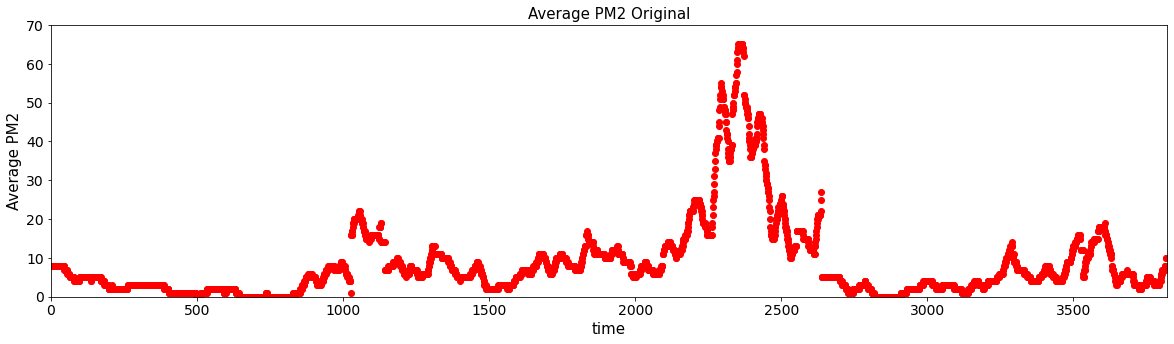

In [13]:
plt.figure(figsize=(20,5))
plt.axis([0,3820, 0, 70])
plt.plot(df_nonan['PM2_MOY'],'ro')
plt.title('Average PM2 Original', size=15)
plt.xlabel('time',size=15)
plt.ylabel('Average PM2',size=15)

Text(0, 0.5, 'PM2 Moyenne')

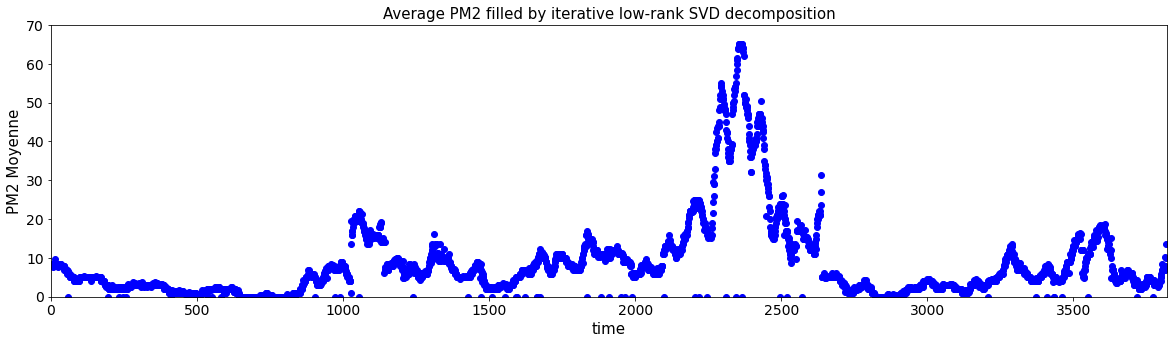

In [14]:
plt.figure(figsize=(20,5))
plt.axis([0,3820, 0, 70])
plt.plot(arr_completedSVD['PM2_MOY'], 'bo')
plt.title('Average PM2 filled by iterative low-rank SVD decomposition', size=15)
plt.xlabel('time', size=15)
plt.ylabel('PM2 Moyenne', size=15)

### Fill of data 

In [15]:
super_df = pd.read_csv('./data/superdfi.csv', header=0, index_col=0)

In [16]:
filldf = super_df.copy(deep=True)
filldf.drop(columns=['Sensor','Date', 'Hour'], inplace=True)

In [17]:
X_incomplete = filldf.to_numpy()

In [18]:
from fancyimpute import IterativeSVD

def fill_iterative_svd():
    solver = IterativeSVD(rank=1, convergence_threshold=0.00000001)
    arr_completed = solver.fit_transform(X_incomplete)
    return arr_completed


arr_completedSVD = test_iterative_svd()

[IterativeSVD] Iter 1: observed MAE=1.935099
[IterativeSVD] Iter 2: observed MAE=1.153091
[IterativeSVD] Iter 3: observed MAE=0.906071
[IterativeSVD] Iter 4: observed MAE=0.819781
[IterativeSVD] Iter 5: observed MAE=0.776393
[IterativeSVD] Iter 6: observed MAE=0.748792
[IterativeSVD] Iter 7: observed MAE=0.730064
[IterativeSVD] Iter 8: observed MAE=0.716992
[IterativeSVD] Iter 9: observed MAE=0.707739
[IterativeSVD] Iter 10: observed MAE=0.701101
[IterativeSVD] Iter 11: observed MAE=0.696335
[IterativeSVD] Iter 12: observed MAE=0.693034
[IterativeSVD] Iter 13: observed MAE=0.690512
[IterativeSVD] Iter 14: observed MAE=0.688600
[IterativeSVD] Iter 15: observed MAE=0.687138
[IterativeSVD] Iter 16: observed MAE=0.686019
[IterativeSVD] Iter 17: observed MAE=0.685160
[IterativeSVD] Iter 18: observed MAE=0.684498
[IterativeSVD] Iter 19: observed MAE=0.683988
[IterativeSVD] Iter 20: observed MAE=0.683593
[IterativeSVD] Iter 21: observed MAE=0.683289
[IterativeSVD] Iter 22: observed MAE=0.6830

In [19]:
super_dfFilled = pd.DataFrame(arr_completedSVD, columns = ['PM2_MIN','PM2_MAX','PM2_MOY'])
super_dfFilled[['Sensor', 'Date', 'Hour']] = super_df[['Sensor', 'Date', 'Hour']]
super_dfFilled = super_dfFilled[['Sensor', 'Date', 'Hour', 'PM2_MIN', 'PM2_MAX', 'PM2_MOY']]
super_dfFilled.head()

Sensor        Date  Hour  PM2_MIN  PM2_MAX   PM2_MOY
0  sensor16v2.csv  2019-08-28     0      8.0      9.0  8.000000
1  sensor16v2.csv  2019-08-28     1      8.0      9.0  8.000000
2  sensor16v2.csv  2019-08-28     2      8.0      9.0  8.000000
3  sensor16v2.csv  2019-08-28     3      8.0      9.0  8.000000
4  sensor16v2.csv  2019-08-28     4      8.0      9.0  8.341102

In [20]:
super_dfFilled.isnull().sum().sum()

0

Text(0, 0.5, 'Average PM2.5')

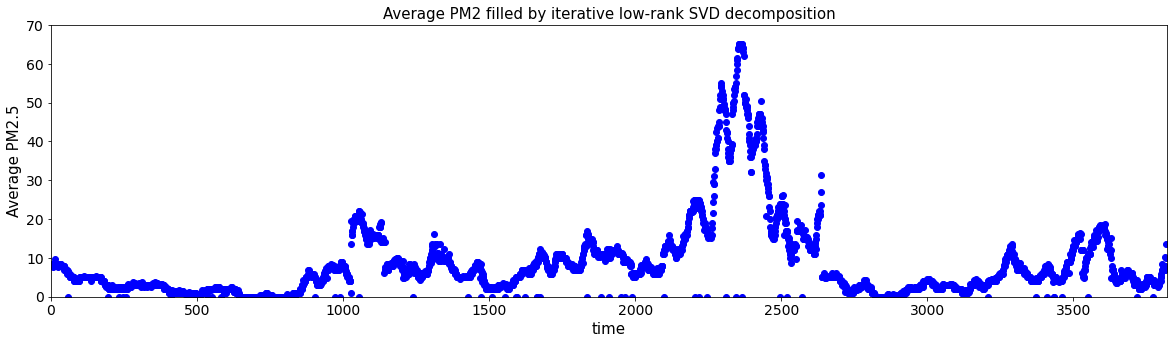

In [21]:
plt.figure(figsize=(20,5))
plt.axis([0,3820, 0, 70])
plt.plot(super_dfFilled['PM2_MOY'], 'bo')
plt.title('Average PM2 filled by iterative low-rank SVD decomposition', size=15)
plt.xlabel('time', size=15)
plt.ylabel('Average PM2.5', size=15)

## **Network implementation**

In this section the implementation of the network is made based on real information about the physical configuration of the sensor network, thanks to the adjacency matrix of the distances between sensors. On the other hand the analysis of the network behavior is made based on a simulated signal of the measurement of the sensors in differents instants in time

### Graph construction
In this section it is described how from real information about the location of the sensors a graph can be built

There is information on the distance between sensors, this is between 0 and 20 (m ?) with this information we proceed to the construction of the final network. Taking into account that it is presented to reach a simple representation of the graph

In [22]:
W = pd.read_csv('data/Pune_SensorLocationDistances.csv',header=0).set_index('0')
W.describe()

1          2          3  ...         52         59         65
count  50.000000  50.000000  50.000000  ...  50.000000  50.000000  50.000000
mean    9.520506   5.964856   5.449465  ...   7.637466   4.977879   7.472454
std     4.025073   3.142605   3.300383  ...   3.990063   2.969335   3.093246
min     0.000000   0.000000   0.000000  ...   0.000000   0.000000   0.000000
25%     7.368550   3.526350   3.523100  ...   5.151775   2.914500   5.896375
50%     9.038300   5.195400   5.203050  ...   7.636500   4.461200   6.981400
75%    11.178000   8.379425   6.377400  ...   9.355275   6.960750   8.654825
max    20.391000  13.028000  13.840000  ...  16.632000  12.441000  15.538000

[8 rows x 50 columns]

In [66]:
fig = px.imshow(W)
fig.update_layout(
    title='Adjacent matrix')
fig.show()

The following chart shows the probability distribution function (PDF ) and the cumulative distribution function (CDF) of the distances in order to analyze and choose the limit to establish the weight between connections. It is observed that the average value of the connections is between 5 and 7 (m ?) and there are few connections greater than 17 (m ?) . If we take a threshold of 5 (m ?) that is, connections greater than this value would be eliminated, 50% of the existing connections would be maintained, and we focus on the sensors that have a certain closeness in space.

In [23]:
fig = go.Figure(data=[go.Histogram(x=W.to_numpy().flatten(),nbinsx=12,histnorm='probability density')])
fig.update_layout(title = "PDF Distances",xaxis_title="Distances")
fig.show()

fig = go.Figure(data=[go.Histogram(x=W.to_numpy().flatten(),nbinsx=12,histnorm='probability density',cumulative_enabled=True)])
fig.update_layout(title = "CDF Distances",xaxis_title="Distances")
fig.show()

To define the weight of an edge connecting two vertices is used the thresholded Gaussian kernel weighting function given by :


$ W_{i,j} = \left\{\begin{matrix}
exp(- \frac{\left | dist(i,j) \right |^{^2}}{2 \theta ^{2}}) &  dist(i,j) \leq k \\ 
0 & otherwise
\end{matrix}\right.$





In [24]:
Theta, k = 4, 5 #Choosen values of k and theta
W_normal = Norm_W(W.copy(),Theta,k) 
A=W_normal.values

In [67]:
fig = px.imshow(W_normal)
fig.update_layout(
    title='Adjacent matrix')
fig.show()

The following chart shows the probability distribution function (PDF ) and the cumulative distribution function (CDF) of the weighted matrix. Most of the connections are between 0 and 0.4, i.e. they have a low weight.

In [25]:
fig = go.Figure(data=[go.Histogram(x=W_normal.to_numpy().flatten(),nbinsx=12,histnorm='probability density')])
fig.update_layout(title = "PDF Distances",xaxis_title="Distances")
fig.show()

fig = go.Figure(data=[go.Histogram(x=W_normal.to_numpy().flatten(),nbinsx=12,histnorm='probability density',cumulative_enabled=True)])
fig.update_layout(title = "CDF Distances",xaxis_title="Distances")
fig.show()

The following graph shows the network with the original values of the adjacent matrix. 

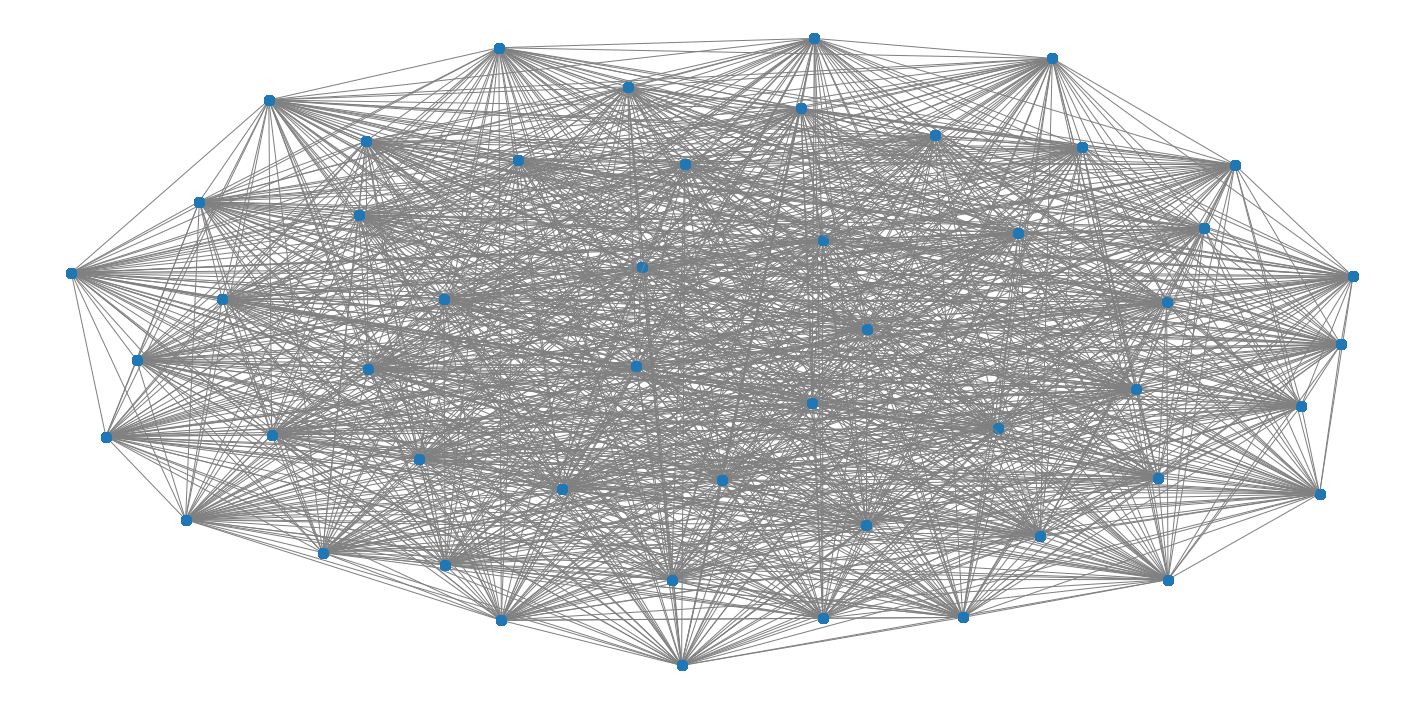

In [26]:
G = create_graph(W)
plot_graph(G)

In [27]:
W_aux=W.copy()
column=W_aux.columns.to_list()
W_aux[column] = W_aux[column].where(~(W_aux[column]>10),other=0)

The following chart shows the W chart limiting the network connections

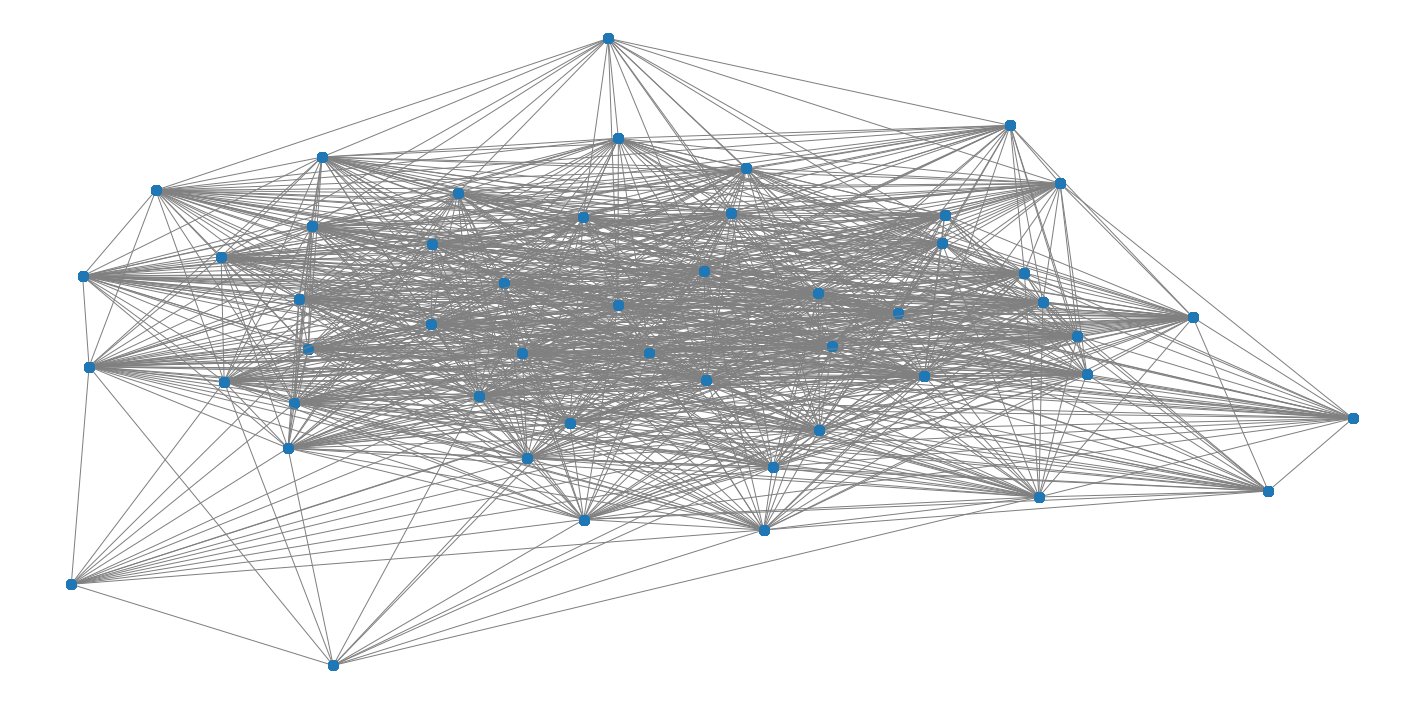

In [28]:
G = create_graph(W_aux)
plot_graph(G)

In the following graph the final network is presented taking into account the smoothing of the network.

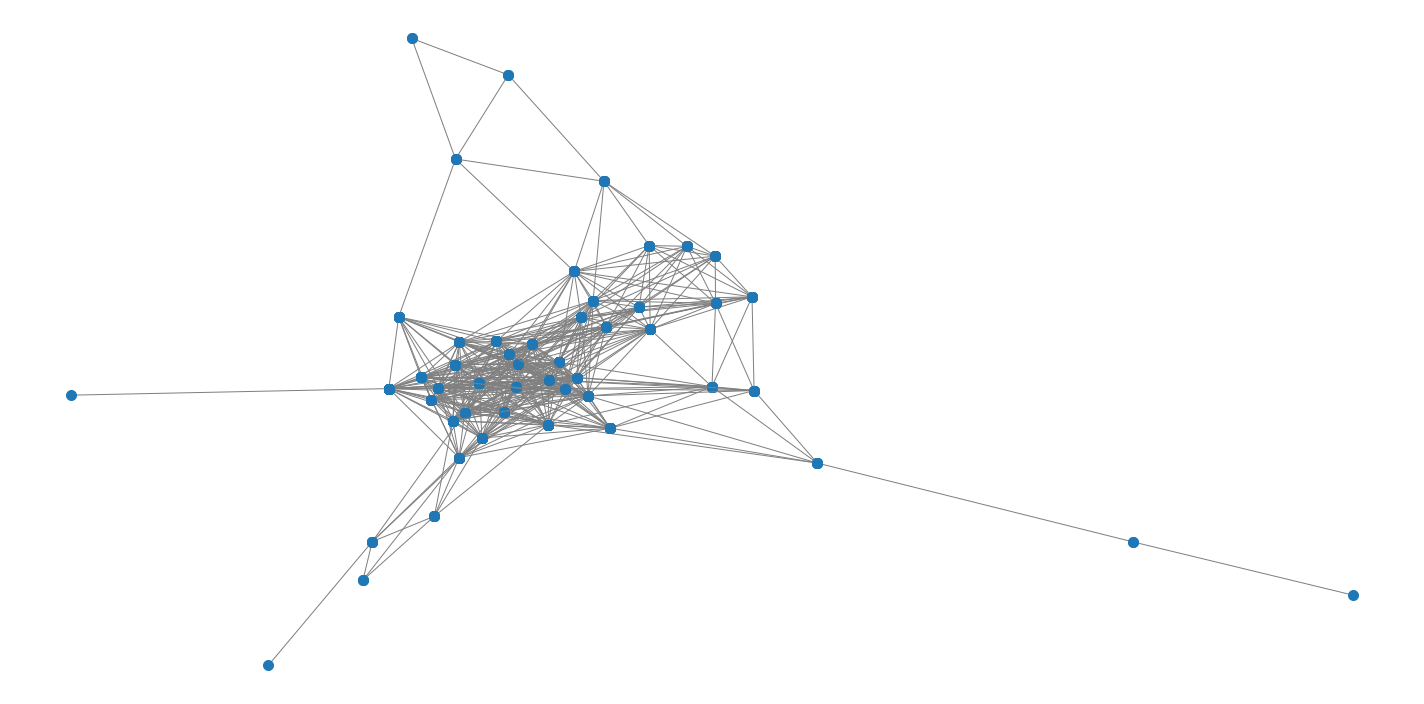

In [29]:
G = create_graph(W_normal)
plot_graph(G)

In [30]:
Theta, k = 4, 5 #Choosen values of k and theta
W_normal = Norm_W(W.copy(),Theta,k) 
A=W_normal.values

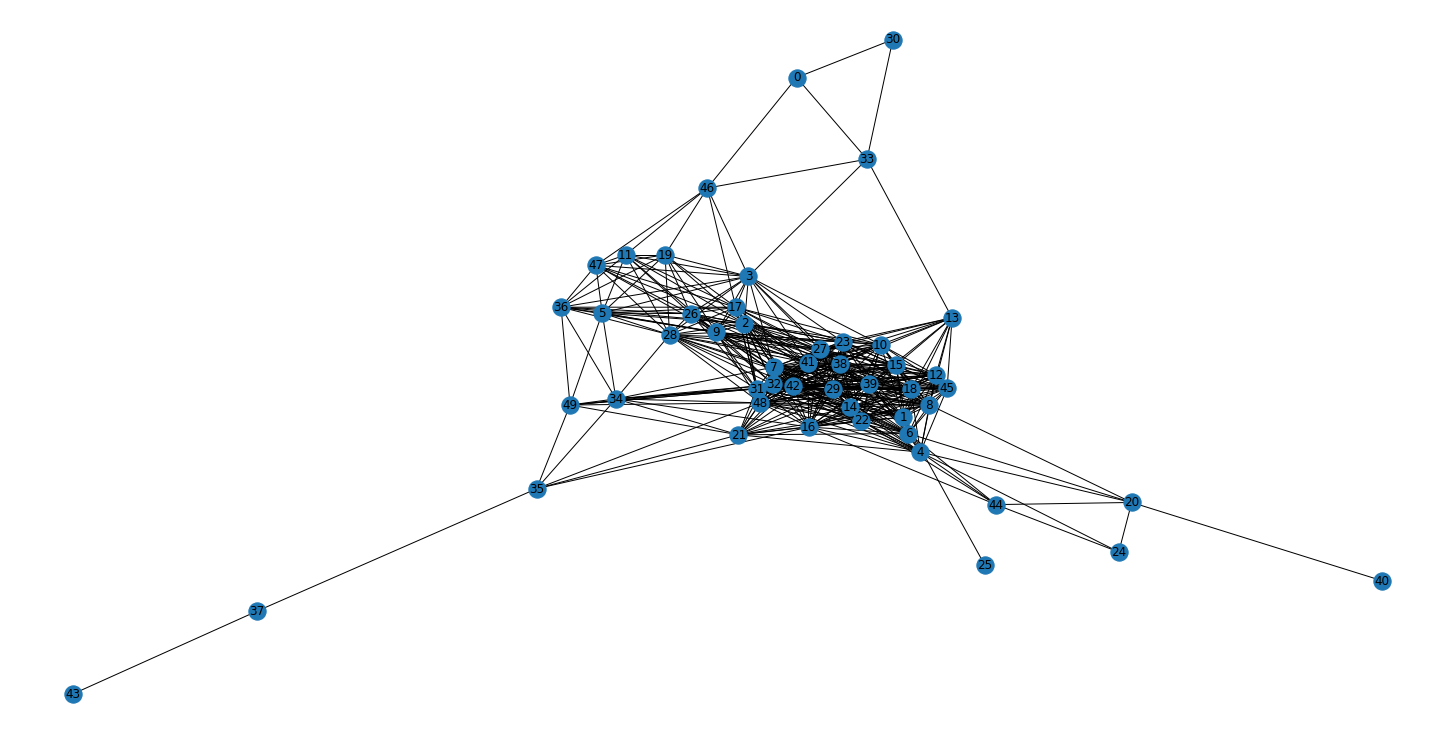

In [31]:
import networkx as nx
dt = [('len', float)]
A = A.view(dt)

G = nx.from_numpy_matrix(A)
pos = nx.spring_layout(G, k=0.5*1/np.sqrt(len(G.nodes())), iterations=50)
figure = pyplot.figure(figsize=(20, 10))
nx.draw(G,pos=nx.spring_layout(G,pos=pos),with_labels = True)
xyz = np.array([pos[v] for v in sorted(G)])

### Graph organization

In this section two methods are presented to reorganize the graph from the information given in the weight matrix

#### Spectral clusterin
This method makes use of the unsupervised spectral clustering algorithm in order to identify nodes that have close distances, and group them in the same set. This in order to obtain a reorganization of the network.
[Source](https://towardsdatascience.com/unsupervised-machine-learning-spectral-clustering-algorithm-implemented-from-scratch-in-python-205c87271045)

Initially Adjacency matrix W, Degree matrix D and the Laplacian matrix to obtain the eigenvalues and eigenvectors of the L matrix.

In [32]:
import matplotlib
from pygsp import graphs

A_s=W_normal.values
graph = graphs.Graph(A_s)
graph.set_coordinates(xyz)
graph.compute_fourier_basis()
e = graph.e
v = graph.U

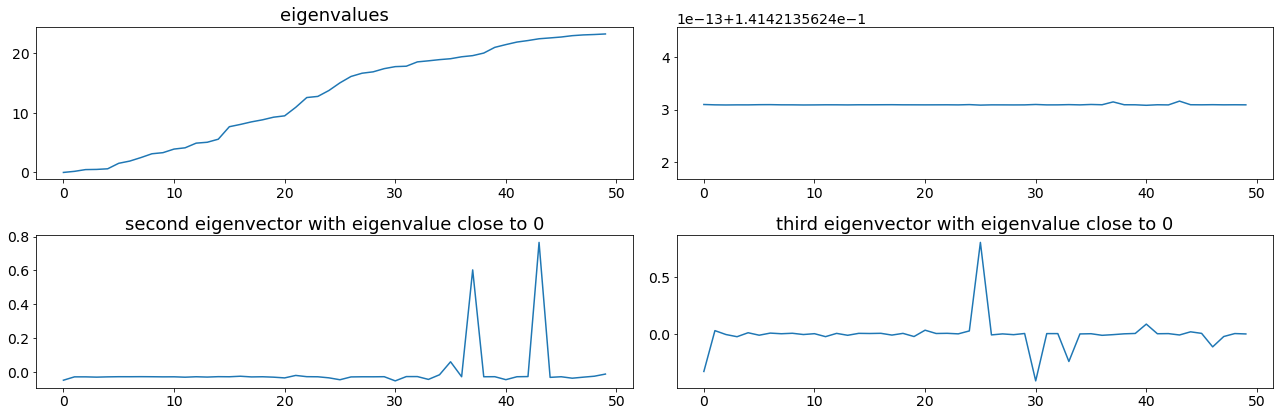

In [33]:
fig = plt.figure(figsize=[18, 6])
ax1 = plt.subplot(221)
plt.plot(e)
ax1.title.set_text('eigenvalues')

i = np.where(e < 20)[0]
ax2 = plt.subplot(222)
plt.plot(v[:, i[0]])
#ax2.title.set_text('first eigenvector with eigenvalue')
ax3 = plt.subplot(223)
plt.plot(v[:, i[1]])
ax3.title.set_text('second eigenvector with eigenvalue close to 0')
ax4 = plt.subplot(224)
plt.plot(v[:, i[2]])
ax4.title.set_text('third eigenvector with eigenvalue close to 0')
fig.tight_layout()

In [34]:
def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Select the eigenvectors corresponding to the first 
    (sorted) num_ev eigenvalues as columns in a data frame.
    """
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: num_ev]

    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df

proj_df= project_and_transpose(e,v,10) #Taking the first 10 eigenvalues to make the analysis

The K-Means algorithm is applied and the inertia is calculated to choose the best possible number of clusters

In [35]:
from sklearn.cluster import KMeans
from sklearn import metrics

inertias = []

k_candidates = range(1, 20)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(proj_df)
    inertias.append(k_means.inertia_)

From the following graph K=10 is chosen because it has an inertia very close to 0

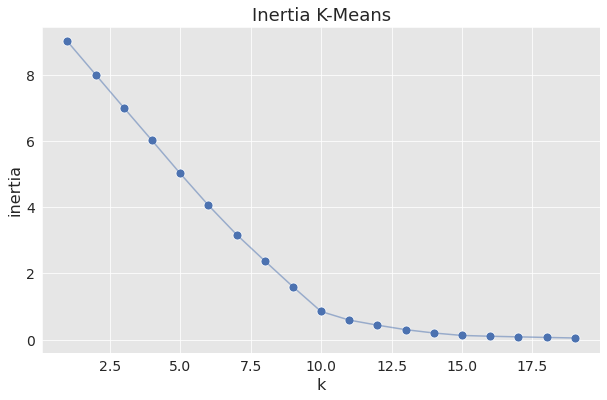

In [36]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

In [37]:
def run_k_means(df, n_clusters):
    """K-means clustering."""
    k_means = KMeans(random_state=25, n_clusters=n_clusters)
    k_means.fit(df)
    cluster = k_means.predict(df)
    return cluster

def spectral_clustering(eigenvals, eigenvcts, n_clusters):
    """Spectral Clustering Algorithm."""
    proj_df = project_and_transpose(eigenvals, eigenvcts, n_clusters)
    cluster = run_k_means(proj_df, proj_df.columns.size)
    return cluster

The algorithm is executed for a number of clusters equal to 10

In [38]:
Index_cluster= spectral_clustering(e,v,10)
index = np.argsort(Index_cluster)

In the following graph you can see the result of the clustering, where each color represents a different group. It is observed that most of the nodes that are physically close are grouped in the same set. This information is used to reorganize the graph.

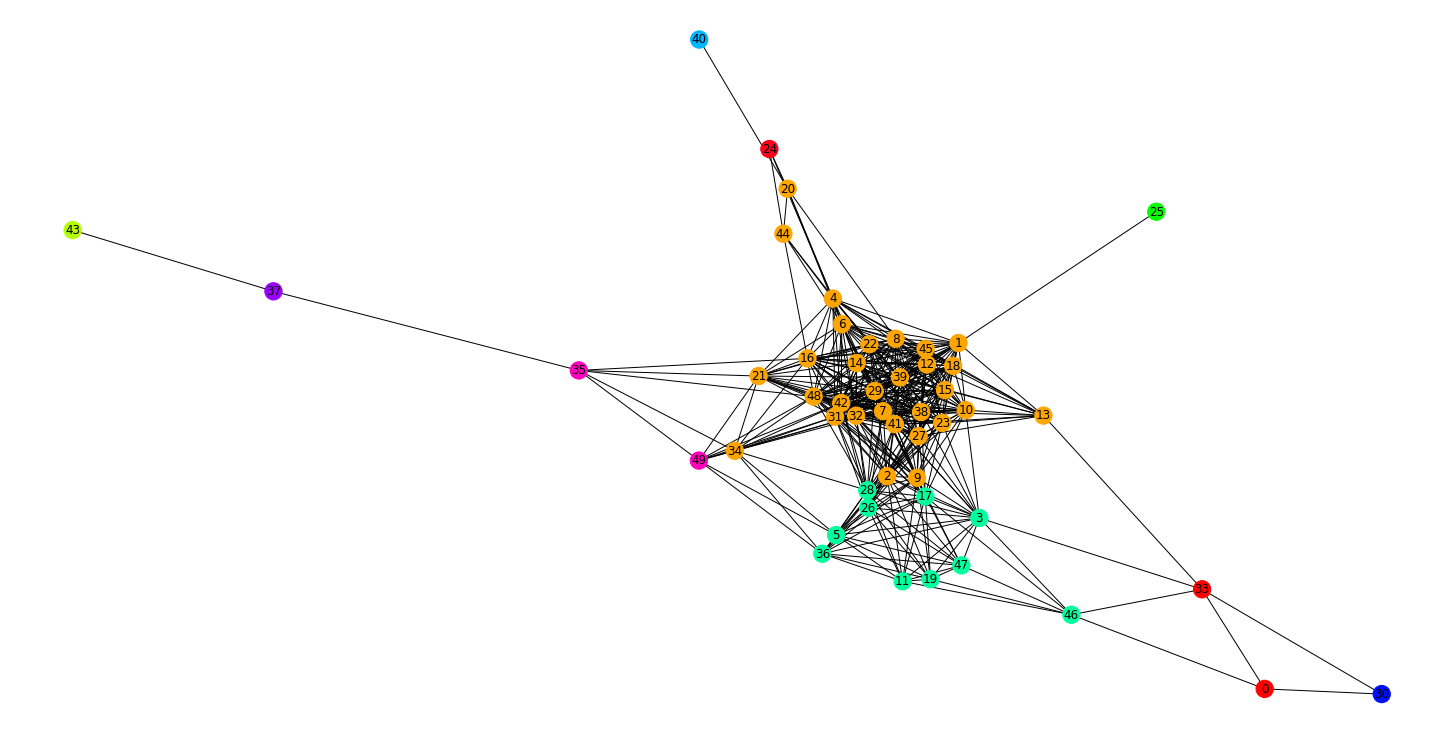

In [39]:
dt = [('len', float)]
A_s = A_s.view(dt)
G = nx.from_numpy_matrix(A_s)
pos = nx.spring_layout(G, k=0.5*1/np.sqrt(len(G.nodes())), iterations=50)
figure = pyplot.figure(figsize=(20, 10))
nx.draw(G,pos=nx.spring_layout(G,pos=pos),with_labels = True,node_color = Index_cluster, cmap = 'hsv')

In [40]:
SortW = W_normal.iloc[index,index]
A_s=SortW.values
Grap_s=A_s

In [68]:
fig = px.imshow(Grap_s)
fig.update_layout(
    title='Adjacent matrix')
fig.show()

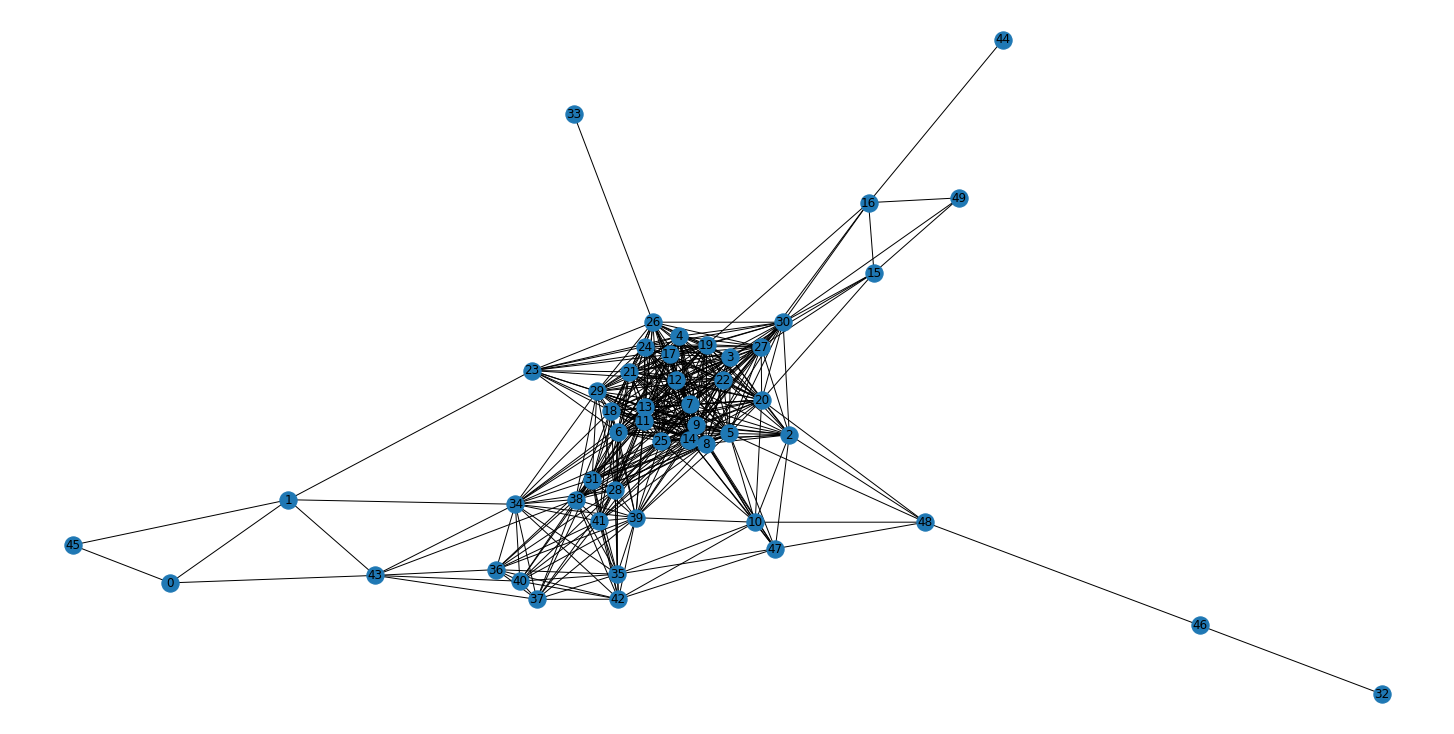

In [41]:

dt = [('len', float)]
A_s = A_s.view(dt)

G = nx.from_numpy_matrix(A_s)
pos = nx.spring_layout(G, k=0.5*1/np.sqrt(len(G.nodes())), iterations=50)
figure = pyplot.figure(figsize=(20, 10))
nx.draw(G,pos=nx.spring_layout(G,pos=pos),with_labels = True)
xyz = np.array([pos[v] for v in sorted(G)])

#### Bandwidth Reduction

The reverse Cuthill–McKee algorithm is an algorithm to permute a sparse matrix that has a symmetric sparsity pattern into a band matrix form with a small bandwidth.

In [42]:
Theta, k = 4, 5
W_normal = Norm_W(W.copy(),Theta,k) #Theta = 0.1 , k = 0.7
A_b=W_normal.values

In [43]:
#Function
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee


def ReOrderGraph(A):
  csrMatrix = csr_matrix(A)
  perm = reverse_cuthill_mckee(csrMatrix)
  A_reorder = csrMatrix[perm, :][:, perm].toarray()
  return A_reorder

def Graph_Nodes(A):
  dt = [('len', float)]
  A = A.view(dt)
  G = nx.from_numpy_matrix(A)
  pos = nx.spring_layout(G, k=0.5*1/np.sqrt(len(G.nodes())), iterations=50)
  figure = pyplot.figure(figsize=(20, 10))
  nx.draw(G,pos=nx.spring_layout(G,pos=pos),with_labels = True)
  xyz = np.array([pos[v] for v in sorted(G)])
  return xyz

In order to apply the algorithm, the "Scipy" library is used, which returns the permutation array that orders a sparse CSR or CSC matrix in Reverse-Cuthill McKee ordering. [source 2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.reverse_cuthill_mckee.html)

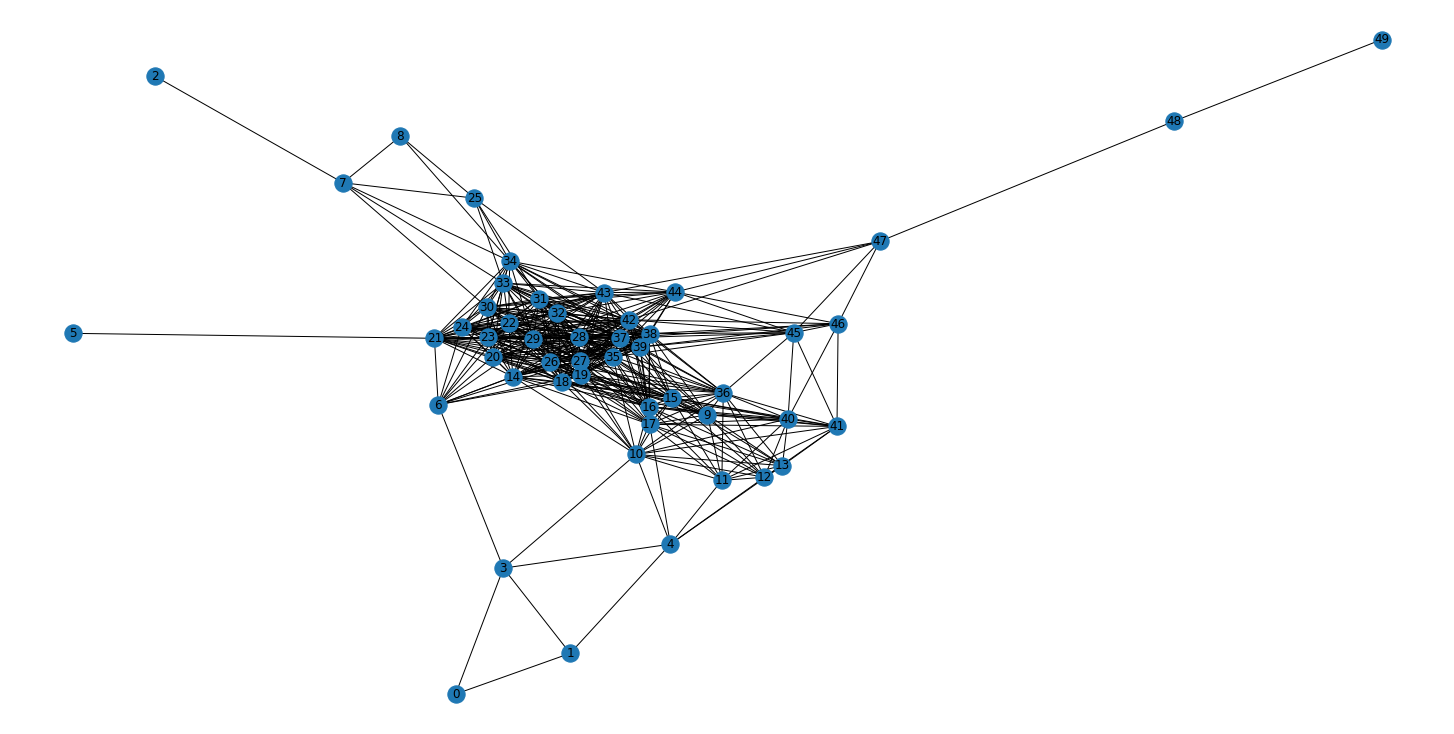

In [44]:
A_reorder = ReOrderGraph(A_b)
xyz = Graph_Nodes(A_reorder)

In [70]:
fig = px.imshow(A_reorder)
fig.update_layout(
    title='Adjacent matrix')
fig.show()

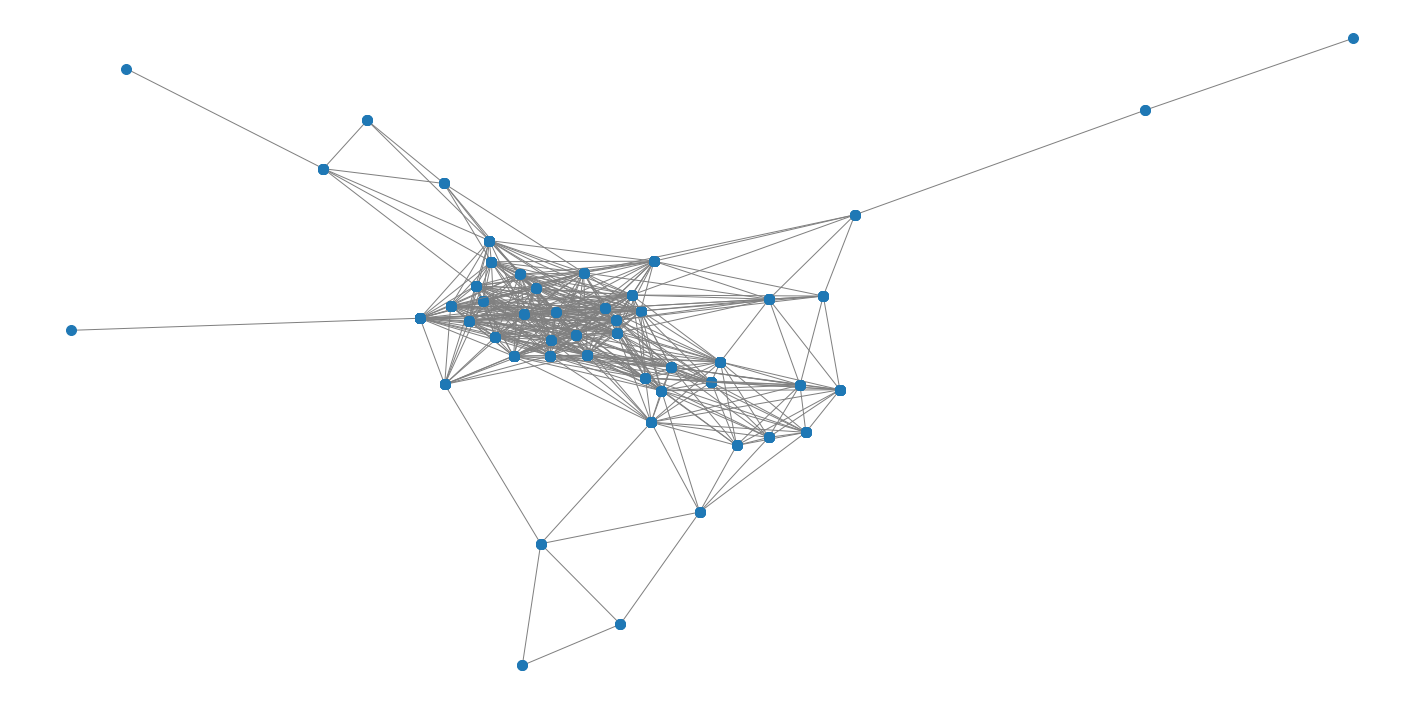

In [45]:
graph = graphs.Graph(A_reorder)
graph.set_coordinates(xyz)
graph.compute_fourier_basis()
plot_graph(graph)

It is observed that with both methods a similar result is obtained, however due to simplicity the Cuthill-McKee band reduction method is chosen

In [46]:
graph = graphs.Graph(A_reorder)
graph.set_coordinates()
graph.compute_fourier_basis()

## **Simulated Drift Implementation**


In this section We will define sinusoidal signals for all the nodes of the network to be analyzed, presenting in the vertex 0 a drift behavior from a certain instant of time. We will then analyze different characteristics of the network using the Graph Fourier Transform (GFT).

In [47]:
matplotlib.rcParams["image.cmap"] = 'viridis'

# Constants
SPACE_GRAPH_ORDER, SPACE_KERNEL_SCALE = graph.N, 5 #40, 3
TIME_GRAPH_ORDER, TIME_KERNEL_SCALE = 50, 100
dT = 10.0/TIME_GRAPH_ORDER # Time sample
LEVEL_NOISE, BREAK_TIME, STD = 0.2, 20, 0.3 # LN, brownian Motion (BM) start-point and SD in BM

### Network in time and space

In the following graph, the two graphs to be analyzed are presented. On the one hand, we have the network of sensors obtained in the previous session, and on the other, we have a path graph which represents the time, in this case 50 different moments. Small groups of nodes are made, in order to simulate similar segmented behavior in the network


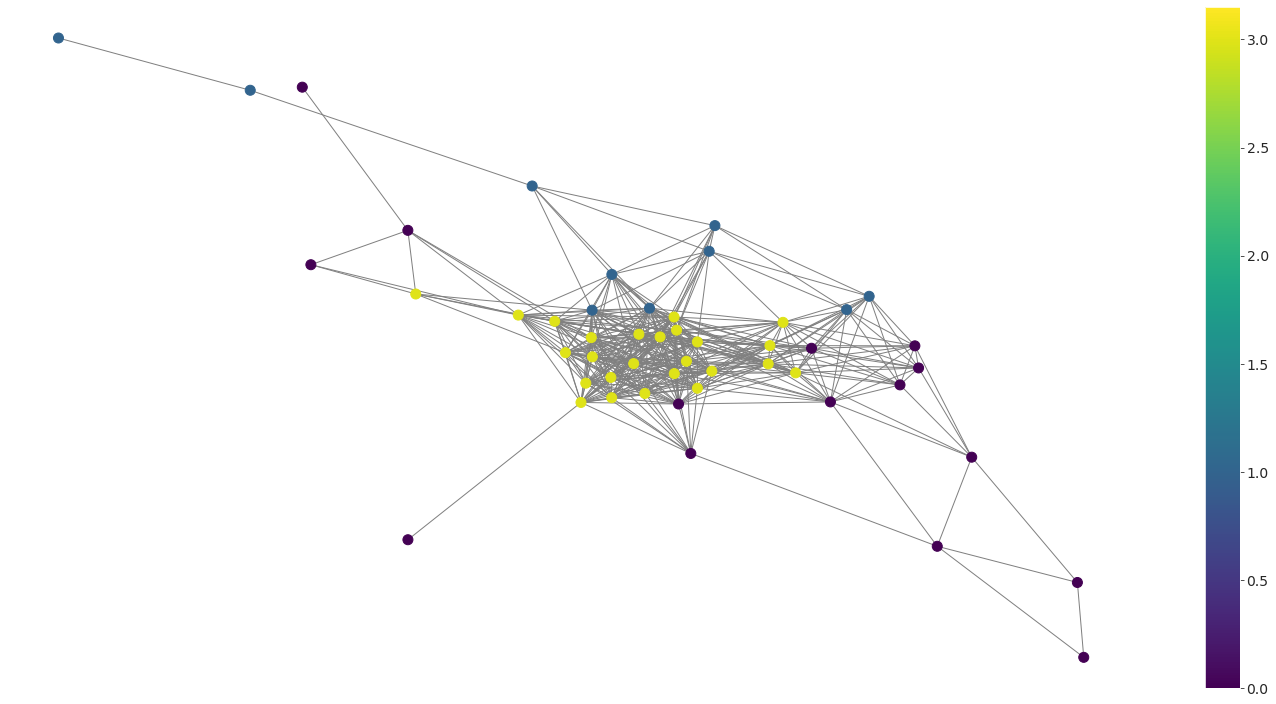

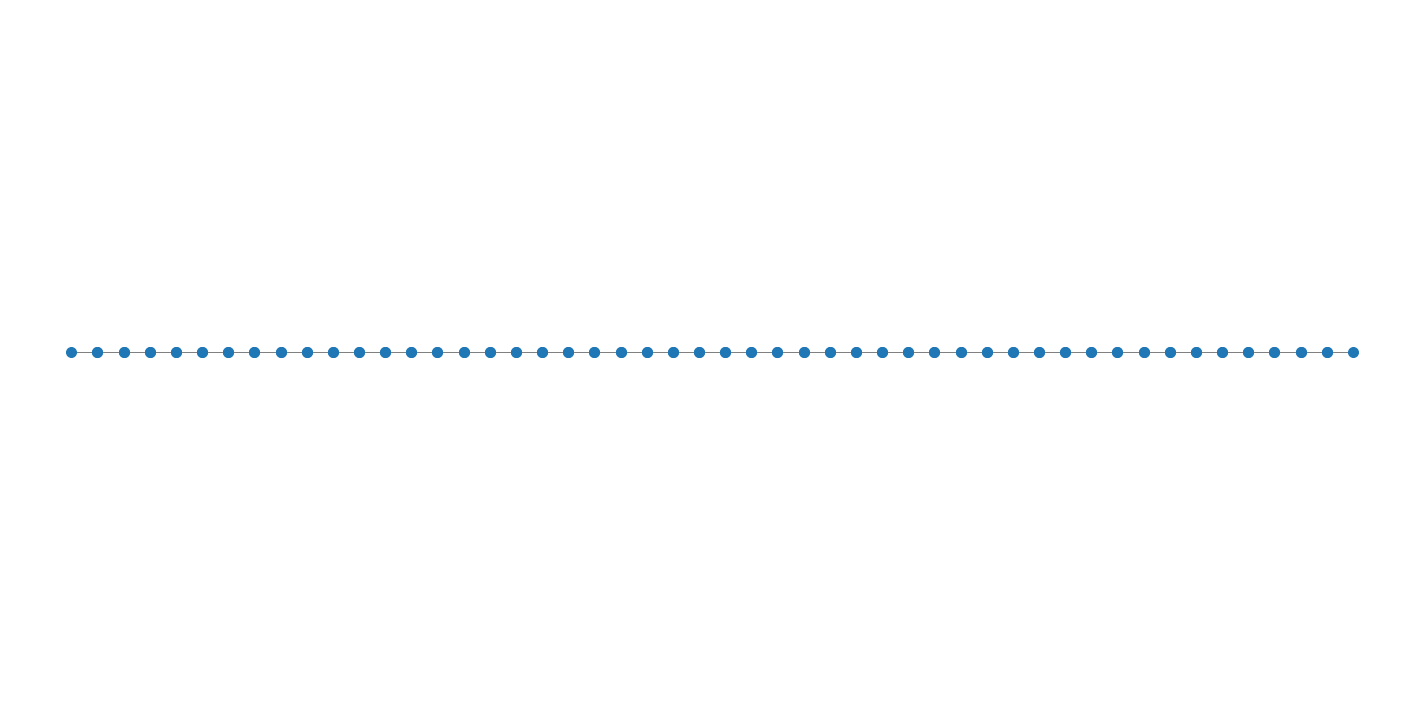

In [48]:
# Space-time graph definition
groups = np.array([0]*15 + [3]*25 + [1]*10)
space_time_graph = [graph, create_path_graph(TIME_GRAPH_ORDER)]

plot_graph(space_time_graph[0],groups)
plot_graph(space_time_graph[1])

### Signal definition
Now we create a function that defines the signal to be implemented on the space network. Let's see how each signal looks in all the vertex.

In [49]:
# Functions to signal definition
def brownian(x0, n, dt, delta, out = None):
    # https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html
    x0 = np.asarray(x0)
    
    # For each element of x0, generate a sample of n numbers from a normal distribution.
    r = np.random.normal(0.0, delta, x0.shape + (n,))*np.sqrt(dt)
    
    # If `out` was not given, create an output array.
    if out is None: out = np.empty(r.shape)
        
    # This computes the Brownian motion by forming the cumulative sum of the random samples. 
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)
    return out
    
def drift_signal(SGO = SPACE_GRAPH_ORDER, TGO = TIME_GRAPH_ORDER, BT = BREAK_TIME, 
                 dT = 1.0, nl = 0.01, delta = 2.0, groups = None, drift_vertex = 0):
    if groups is None:
        signal = np.sin(np.linspace(0, (TGO//BT)*4*np.pi, TGO)) # Signal base (until BREAK_TIME)
        time_series = np.ones((SGO,1))*signal[None] # Same signal for all nodes
    else:
        time_series = []
        for i in groups:
            t0 = 2*np.pi*i/len(np.unique(groups))
            time_series += [np.sin(np.linspace(0,(TGO//BT)*4*np.pi, TGO) + t0)]
        time_series = np.stack(time_series, axis = 0)
            
    time_series += nl * np.random.randn(*time_series.shape) # Add noise
    
    # Add Brownian Motion with t = BT start point
    brownian(time_series[drift_vertex,BT - 1], TGO - BT, dT, delta, out = time_series[drift_vertex,BT:])
    return time_series

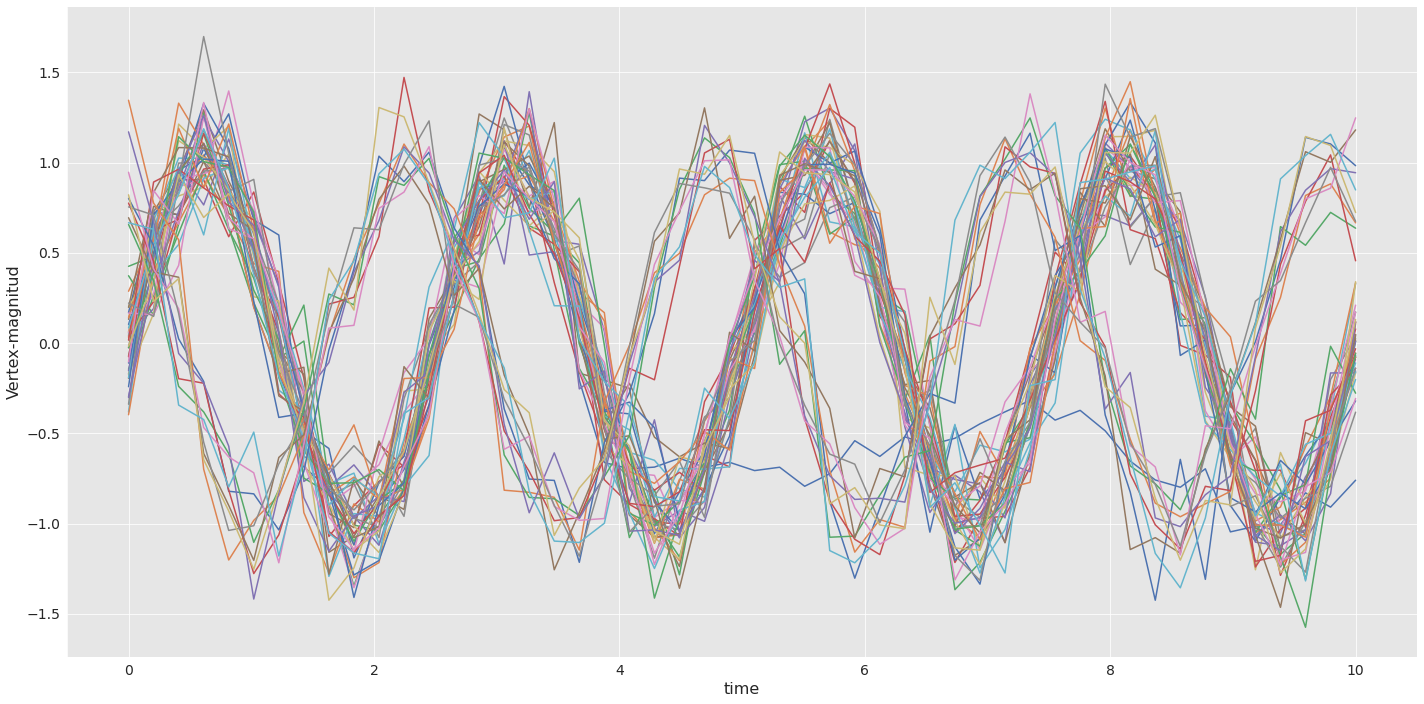

In [50]:
# Signal definition
#groups = np.array([0]*25 + [1]*25)
groups = np.array([0]*15 + [3]*25 + [1]*10)

time_series = drift_signal(dT = dT, nl = LEVEL_NOISE, BT = BREAK_TIME, delta = STD, groups = groups)

t = np.linspace(0, TIME_GRAPH_ORDER*dT, TIME_GRAPH_ORDER)
t = np.ones((SPACE_GRAPH_ORDER,1))*t[None]
plot_curves(t, time_series, xlabel = "time", ylabel = "Vertex-magnitud")

The next graph shows the signal inside the space-time graph in a given time. For example, at time instant 3, it is observed that the network is divided into two sections because the signal strength is inverse for the groups created, that is, one group of nodes has a high value while the other has a low.

In [71]:
signal_graph_anima(space_time_graph, time_series)

interactive(children=(Dropdown(description='instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function libraries.animation_utils.signal_graph_anima.<locals>.update>

### GFT in time and space

In this section we present functions to calculate the graph fourier transform in time and space

To check that the desired signal was processed correctly, the signal on a particular node and its Graph Fourier Transform (GFT) can be displayed with the following code section. 

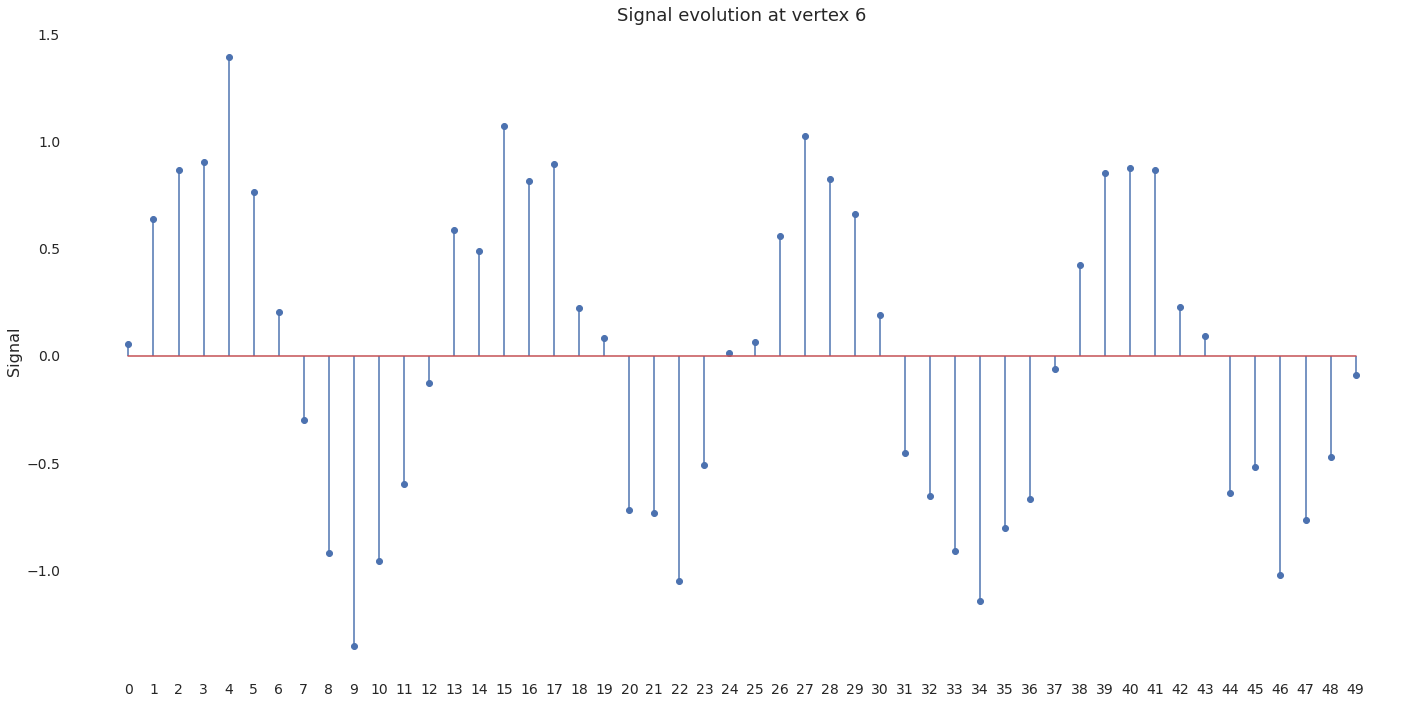

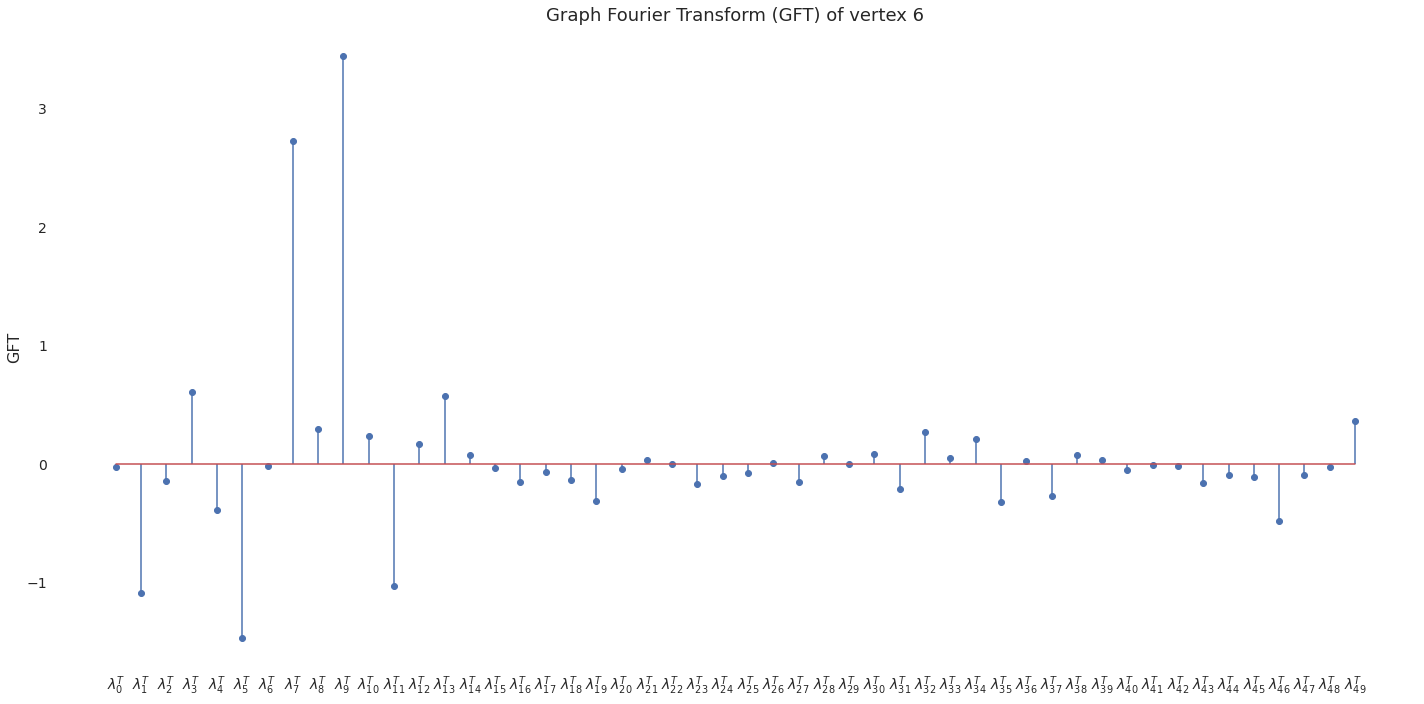

In [52]:
gft_signal_anima(space_time_graph[1], time_series, is_graph_space = True)

From the graph above it can be seen that the signal at node 0 (where the drift occurs) most of its energy is concentrated in the low frequencies, in other words in the eigenvalues close to 0. For the other nodes, there are higher frequencies, being these on the seventh eigenvalue.

This behavior is explained having in mind that after the drift, the signal in the 0 vertex presents a constant decrease, while in the rest of sensors the sinusoidal signal continues its periosity. 

In [72]:
gft_signal_anima(space_time_graph[0], time_series, is_graph_space = False)

interactive(children=(Dropdown(description='Instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function libraries.animation_utils.gft_signal_anima.<locals>.update>

From the graph above, it is observed that in general, the frequency components in time are found in greater magnitude at low levels, however they present in higher frequencies, because the signal in a moment of time varies in the network in general. After the drift in certain instants, it is observed greater power in high frequencies / eigenvalues

### Spectrogram for disjoint GFT

To have a more detailed understanding, we will first analyze the graphs separately. The following function allows to display the spectrogram of each network by selecting a specific time (for the spatial graph) or a specific vertex (for the temporal graph), depending on the case.

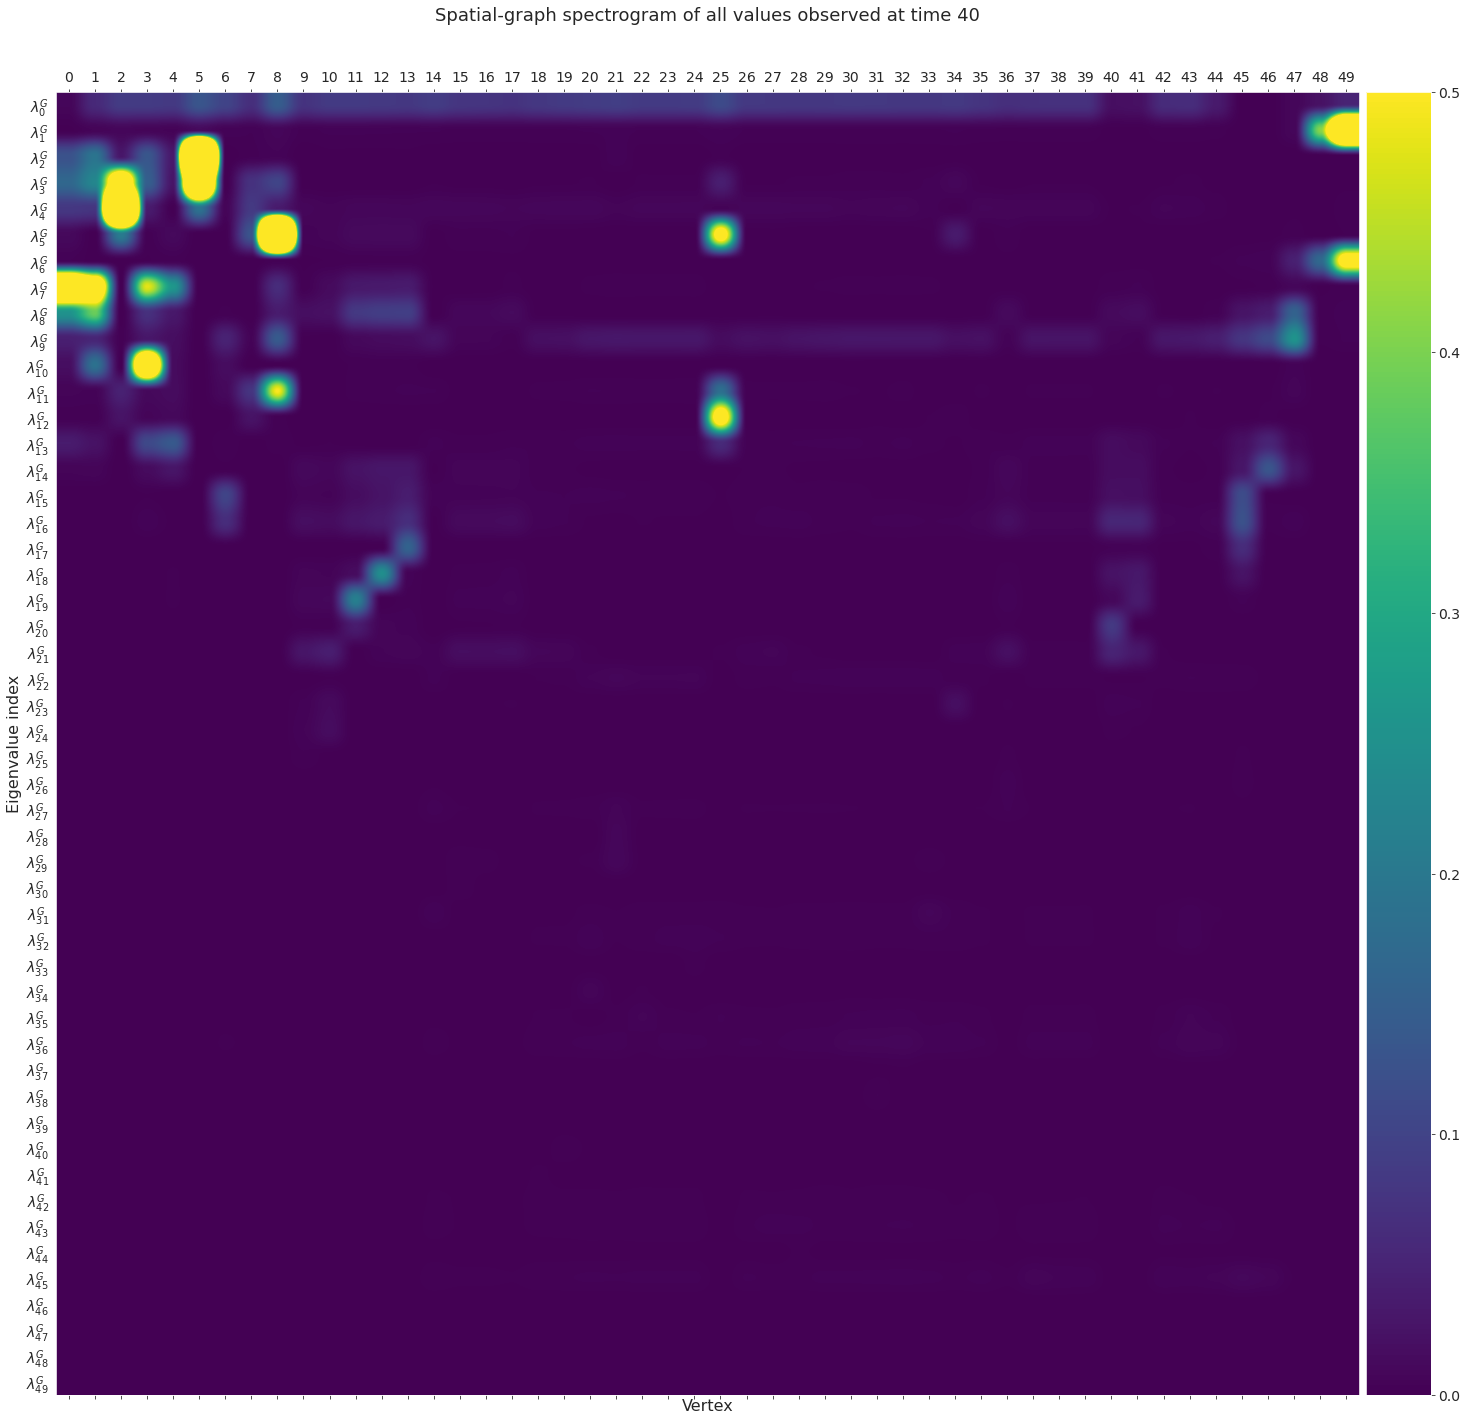

In [73]:
spectogram_anima(space_time_graph[0], time_series, SKS = SPACE_KERNEL_SCALE, is_graph_space = True, limits = [0.0, 0.5])

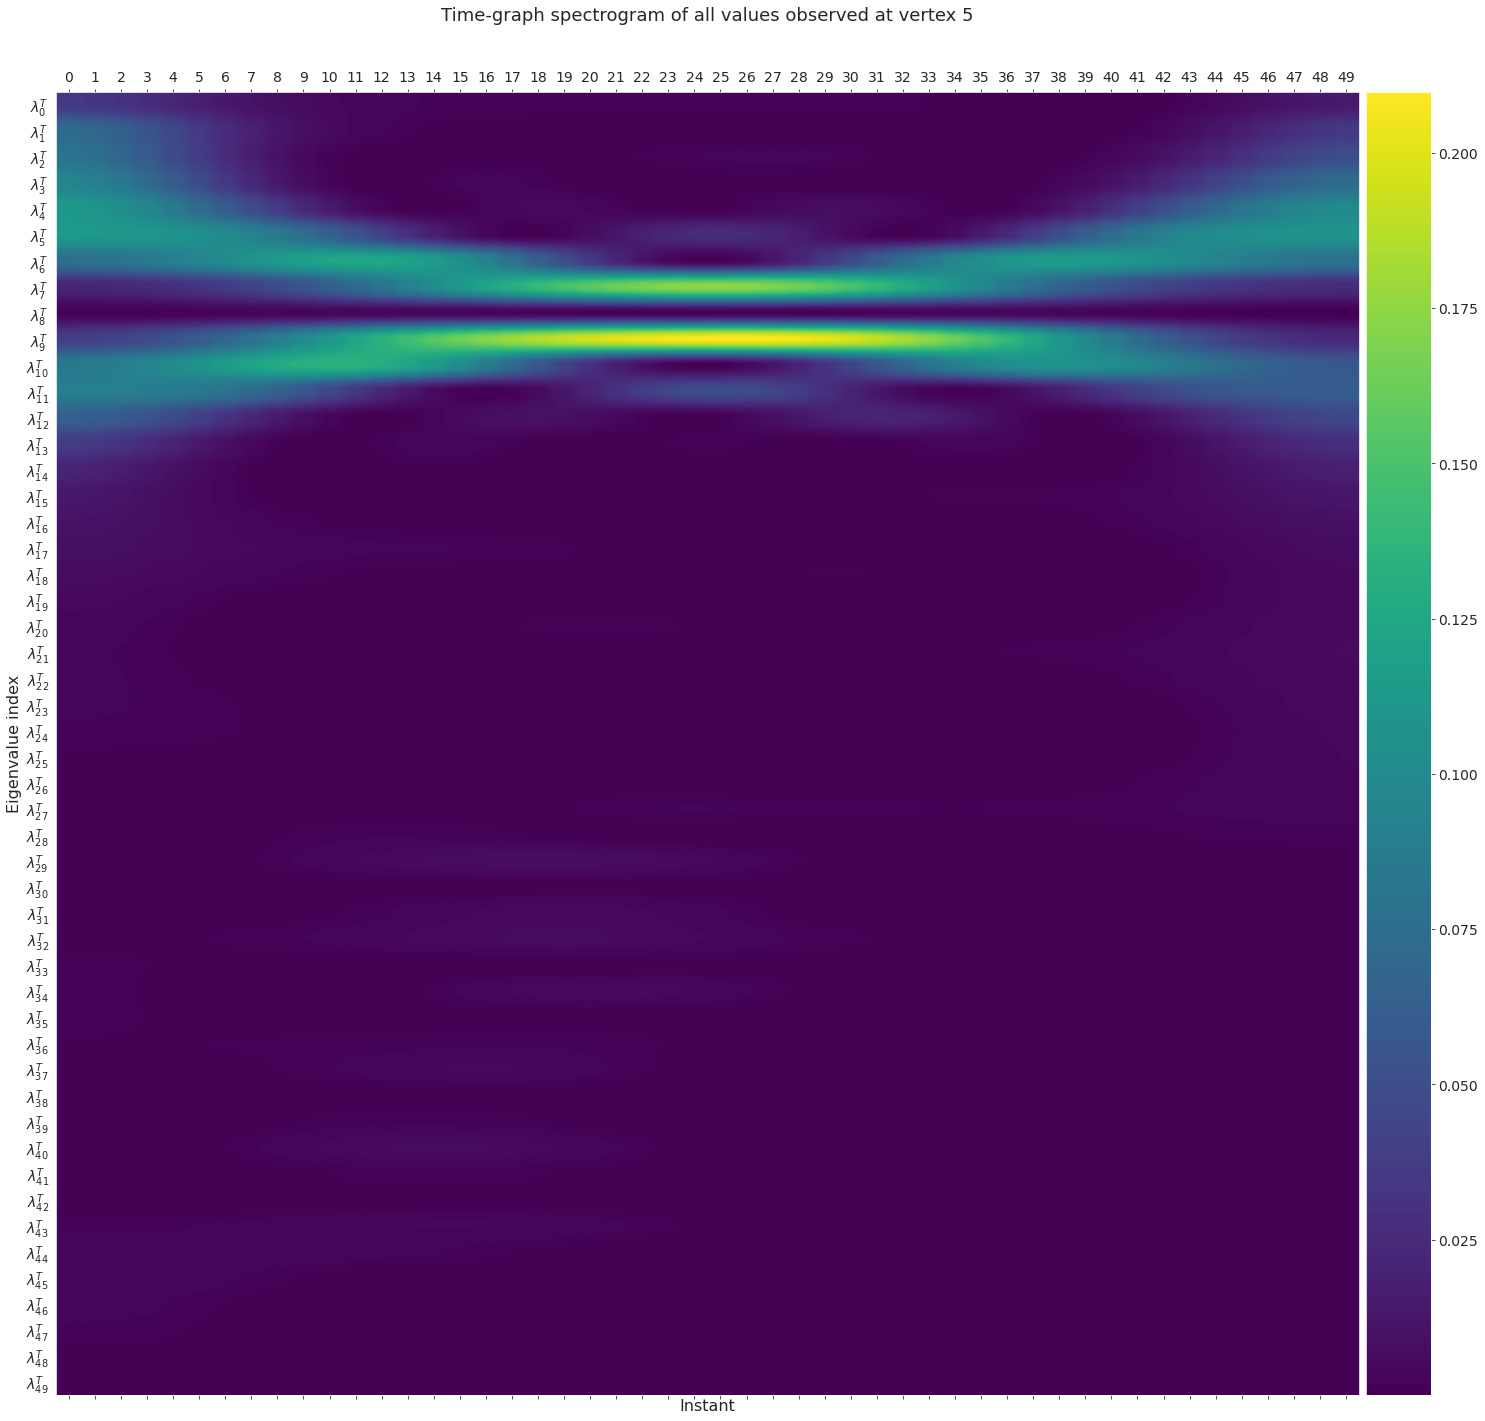

In [55]:
spectogram_anima(space_time_graph[1], time_series, SKS = TIME_KERNEL_SCALE, is_graph_space = False, limits = None)

* **Spatial-graph:** It is important to consider that the same signal is passed through a certain group of vertices $s(v,t_{i})$. It is observed that before the drift there is high power at low frequency in these vertices, after the drift higher frequency components are observed with high power values, corresponding in turn to the "group".

* **Time-graph:** Focusing on the signal from only one particular node $s(v_{i},t)$, it is easy to determine which vertex is faulty, since the respective spectrogram differs greatly from the other vertices, even though the signal of all should be the same. For the vertex 0, it is observed that before the drift (instant 20) the frequency component is high and after it is reduced to eigenvalues close to zero, behavior that is explained because after the drift the signal decreases progressively 

### Spectrogram for joint GFT (JFT)
Now we will enter to observe the properties of the space-time joint spectrogram. This is possible thanks to the following function. Since the joint spectrogram is in principle a two-dimensional array for each possible combination in space and time, we have as a result an array in $\mathbb{R}^4$, being useful to indicate a specific vertex and instant, looking for interpretability.

In [76]:
kernels, joint_spectogram = JFT_anima(space_time_graph, time_series, [SPACE_KERNEL_SCALE, TIME_KERNEL_SCALE])

interactive(children=(Dropdown(description='instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

Taking into account that the joint spectrogram estimates different spectrograms, each of them centered on the combination ($v_i$, $t_j$), the analysis of the results should be done for each possible combination, arriving at the following statements:

1.  As explained above, the process occurs at "low frequencies" for any possible event, in time, which directly affects the joint spectrogram, being only possible to see non-zero magnitudes in the upper left region (low orders of eigenvalues in time).
2.  The signal $s(v_i,t)$ has more frequency components compared to the signal $s(v,t_i)$, being possible to observe in the spectrogram for any combination. 


## **Real signal analysis**

By observing a first view of the behavior of a signal that presents drift in one of its nodes, in order to understand its spectral representation, we can begin to analyze the signals captured by the sensor network. To do this, we must take a reading of the gas to be analyzed: PM, which is a measure of how polluted the air is at a location. We will then build a matrix containing the signal from each sensor per hour, from August 28 to October 28, 2019.

### Data read
Let's start with the reading of the signals, contained in the directory `air-polution-sensor/data/sensorv2/`.

In [57]:
def readFileList(file_directory, ext = 'csv'): # Read a valid json-files inside folder / independenly file
    files_list = []
    if os.path.isdir(file_directory): # Return files with 'json' extension
        for root_path, _, files_name in os.walk(file_directory):
            files_list += [os.path.join(root_path, x) for x in files_name if x.split(".")[-1].lower() == ext.lower()]
    elif file_directory.split('.')[-1] == ext: files_list = [file_directory] # Return file inside of list
    return files_list

def sensor_read_signal(signal_name = "PM2_MOY"): # Read all signals and join in one matrix
    signals_list = readFileList("./data/sensorv2")
    signals = None
    for signal_file in signals_list:
        new_col_name = os.path.split(signal_file)[-1].replace("v2.csv","").replace("sensor","")
        new_col_name = int(new_col_name) # Only keep sensor id
        sig = pd.read_csv(signal_file).rename(columns = {signal_name: new_col_name}) # Read signal
        sig["Date"] = pd.to_datetime(sig["Date"] + " " + sig["Hour"].astype(str) + ":00:00")
        sig.set_index("Date", inplace = True)
        # Merge by date
        if signals is None: signals = sig[[new_col_name]].copy()
        else: signals = signals.merge(sig[[new_col_name]], copy = False, left_index = True, right_index = True)
    signals = signals.sort_index().T
    
    # Fill empty sensors with NaN values
    start, end = signals.index.min(), signals.index.max() # Find empty frames and fill in
    empty_sensors = sorted(set(range(start, end + 1)).difference(signals.index.values))
    if len(empty_sensors) > 0: 
        signals = signals.reindex(signals.index.to_list() + empty_sensors).fillna(0.0) # Comment fillna(0.0) to return NaN values
    return signals.sort_index().values # Comment .values to return dataframe

time_sensors_series = sensor_read_signal()
print(time_sensors_series.shape)
time_sensors_series#.head(30)

(59, 1488)


array([[400., 400., 400., ..., 400., 400., 400.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [400., 400., 400., ..., 400., 400., 400.]])

## ***Anexos: GitHub-Colab connection***
Here, some commands to upload/save the github respository

In [58]:
''' Function definitions'''
# Git pull
def git_pull(repo_pwd, show_current_branch = False, make_commit = False): # Only for colab space work
    global user_git, email_git
    import sys
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/gdrive')

        %cd "$repo_pwd"
        # !git config --list
        if show_current_branch: 
            !git branch 
        if make_commit:
            if "user_git" not in globals(): user_git = input("User github?: ")
            if "email_git" not in globals(): email_git = input("Email github?: ") 
            !git config --global user.email $email_git
            !git config --global user.name $user_git
            !git commit -am "Updating in colab"
        !git pull
        !git status
    else:
        print("[INFO] You are not in collaboration, nothing has been done.")

# Git push
def git_push(repo_pwd): # Only for colab space work
    global user_git, email_git
    import sys
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        from google.colab import drive
        import getpass
        drive.mount('/content/gdrive')

        %cd "$repo_pwd"
        if "user_git" not in globals(): user_git = input("User github?: ")
        if "email_git" not in globals(): email_git = input("Email github?: ")

        # Password login
        try: 
            pwd_git = getpass.getpass(prompt='{} github password: '.format(user_git)) 
        except Exception as error: 
            print('ERROR', error) 

        # Upload from every where
        origin_git = !git config --get remote.origin.url
        origin_git = origin_git[0].replace("https://","https://{}:{}@".format(user_git,pwd_git))

        !git config --global user.email "$email_git"
        !git config --global user.name "$user_git"
        !git status

        x = " "
        while x.lower() != "y" and x.lower() != "n": x = input("Continue?...[y/n]: ")

        if x.lower() == "y":
            com_message = input("Enter the commit message: ")
            !git add .
            !git commit -am "$com_message"
            !git push "$origin"
            !git status
    else:
        print("[INFO] You are not in collaboration, nothing has been done.")

In order to execute the functions, please unlock the respective function

In [59]:
# git_pull(repo_pwd, show_current_branch = False, make_commit = True)
# git_push(repo_pwd)